In [56]:
import pandas as pd
import pickle
import yaml
import numpy as np
import uuid
from datetime import datetime, timedelta
import math
import random
from matplotlib import pyplot as plt
from adjustText import adjust_text
import os

import warnings
warnings.filterwarnings('ignore')

In [38]:
random.seed(42)
np.random.seed(42)

In [39]:
def generate_trajectory_data(
    num_devices=5,
    duration_minutes=60,
    interval_seconds=60,
    start_datetime=datetime(2022, 9, 6, 7, 30),
    center_lat=55.8935,
    center_lon=37.6028,
    output_path="generated_trajectory_data.parquet"
):
    """
        Генерация траекторий девайсов.
    
    Параметры:
    -----------
    num_devices : int
        Количество генерируемых девайсов
    duration_minutes : int
        Длительность генерации в минутах
    interval_seconds : int
        Интервал между точками данных в секундах
    start_datetime : datetime
        Начальная дата и время
    center_lat, center_lon : float
        Центральная точка генерации
    output_path : str
        Путь к файлу траектории
    """
    # Генерация ID девайсов
    device_ids = [str(uuid.uuid4()) for _ in range(num_devices)]
    
    # Инициализация локаций девайсов
    # Начальные точки с небольшими различиями вокруг центра
    device_locations = {}
    for dev_id in device_ids:
        # Начальная точка с небольшими различиями вокруг центра
        device_locations[dev_id] = {
            'lat': center_lat + np.random.uniform(-0.003, 0.003),
            'lon': center_lon + np.random.uniform(-0.003, 0.003),
            # Параметры движения для этого девайса
            'speed': np.random.uniform(0.5, 2.0),  # m/s
            'direction': np.random.uniform(0, 2*math.pi),
            'next_direction_change': np.random.randint(5, 15)  # интервалы
        }
    
    # Вычисление количества временных интервалов
    num_intervals = (duration_minutes * 60) // interval_seconds
    
    # Генерация временных меток
    timestamps = [start_datetime + timedelta(seconds=i*interval_seconds) for i in range(num_intervals)]
    
    rows = []
    
    # Генерация данных о движении для каждой временной метки
    for idx, current_time in enumerate(timestamps):
        # Обновление локаций девайсов
        for dev_id in device_ids:
            loc = device_locations[dev_id]
            
            # Случайная смена направления
            if idx % loc['next_direction_change'] == 0:
                # Плавная смена направления
                loc['direction'] += np.random.uniform(-0.5, 0.5)
                loc['next_direction_change'] = np.random.randint(5, 15)
                
                # Вариация скорости
                loc['speed'] *= np.random.uniform(0.8, 1.2)
                # Скорость в разумных пределах
                loc['speed'] = max(0.5, min(2.5, loc['speed']))
            
            # Вычисление движения в метрах
            distance = loc['speed'] * interval_seconds
            
            # Преобразование в изменение широты и долготы
            # ~111,000 метров на градус широты
            # ~85,000 метров на градус долготы на этой широте
            lat_change = (distance * math.cos(loc['direction'])) / 111000
            lon_change = (distance * math.sin(loc['direction'])) / (85000 * math.cos(math.radians(loc['lat'])))
            
            # Обновление местоположения
            loc['lat'] += lat_change
            loc['lon'] += lon_change
            
            # Хранение обновленного местоположения
            device_locations[dev_id] = loc
        
        # Для каждой временной метки создаем строки для пар устройств
        for i, dev_id_1 in enumerate(device_ids):
            for j, dev_id_2 in enumerate(device_ids):
                if i >= j: 
                    continue
                    
                loc1 = device_locations[dev_id_1]
                loc2 = device_locations[dev_id_2]
                
                # Вычисление расстояния между устройствами
                lat_dist = (loc1['lat'] - loc2['lat']) * 111000  # в метрах
                lon_dist = (loc1['lon'] - loc2['lon']) * 85000 * math.cos(math.radians((loc1['lat'] + loc2['lat'])/2))
                distance = math.sqrt(lat_dist**2 + lon_dist**2)
                
                # Генерация коррелирующих признаков на основе расстояния
                # Ближайшие устройства имеют набольшую корреляцию
                correlation_factor = max(0.05, min(0.9, 1.0 / (1 + distance/1000)))
                
                row = {
                    'date': current_time.date().isoformat(),
                    'datetime': current_time.isoformat(sep=' '),
                    'dev_id_1': dev_id_1,
                    'id_1_last_lon': loc1['lon'],
                    'id_1_last_lat': loc1['lat'],
                    'dev_id_2': dev_id_2, 
                    'id_2_last_lon': loc2['lon'],
                    'id_2_last_lat': loc2['lat'],
                }
                
                for feature in ['accelerometer_x', 'accelerometer_y', 'accelerometer_z',
                              'x_metres', 'y_metres', 'height', 'bearing', 'speed']:
                    row[f'{feature}_corr'] = correlation_factor * np.random.uniform(0.001, 0.9)
                    row[f'{feature}_diff_corr'] = correlation_factor * np.random.uniform(0.001, 0.1)
                
                row['speed_mean_abs_diff'] = np.random.uniform(0.5, 5.0) * (1 - correlation_factor)
                row['speed_mean_diff'] = np.random.uniform(-2.0, 2.0) * (1 - correlation_factor)
                row['speed_std_diff'] = np.random.uniform(1.0, 12.0) * (1 - correlation_factor)
                row['distance_mean'] = distance
                row['distance_std'] = distance * np.random.uniform(0.1, 0.9)
                
                rows.append(row)
    
    df = pd.DataFrame(rows)
    df.rename(columns={'x_metres_diff_corr': 'x_diff_metres_corr', 'y_metres_diff_corr': 'y_diff_metres_corr'}, inplace=True)
    
    df.to_parquet(output_path, index=False)

    return df

In [40]:
def generate_targets_df(
    input_trajectory_path="generated_trajectory_data.parquet",
    output_path="generated_targets.parquet",
    related_percentage=0.2  # Доля устройств, которые будут считаться связанными
):
    """
    Генерация датафрейма таргетов
    
    Параметры:
    -----------
    input_trajectory_path : str
        Путь к файлу с траекториями
    output_path : str
        Путь к файлу с таргетами
    related_percentage : float
        Доля связанных устройств (от 0.0 до 1.0)
    """
    try:
        trajectory_df = pd.read_parquet(input_trajectory_path)
        print(f"Loaded trajectory data with {len(trajectory_df)} rows")
    except Exception as e:
        print(f"Error loading trajectory data: {e}")
        return None
    
    # Получение уникальных устройств и дат
    unique_devices = list(set(trajectory_df['dev_id_1'].unique().tolist() + 
                             trajectory_df['dev_id_2'].unique().tolist()))
    unique_dates = trajectory_df['date'].unique()
    
    # Создание всех возможных комбинаций устройств
    device_pairs = []
    for i, dev1 in enumerate(unique_devices):
        for dev2 in unique_devices[i+1:]:
            device_pairs.append((dev1, dev2))
    
    # Выбор подмножества пар для обозначения как связанных (target=1)
    num_related_pairs = max(1, int(len(device_pairs) * related_percentage))
    related_pairs = random.sample(device_pairs, num_related_pairs)
    
    targets_data = []
    
    for date in unique_dates:
        # Для каждой даты назначаем некоторые из связанных пар
        date_pairs = random.sample(related_pairs, max(1, int(len(related_pairs) * 0.7)))
        
        for dev1, dev2 in date_pairs:
            # Определяем, какое устройство будет первым и какое вторым
            if random.random() < 0.5:
                init_name, sec_name = dev1, dev2
            else:
                init_name, sec_name = dev2, dev1
                
            targets_data.append({
                'date': date,
                'init_name': init_name,
                'sec_name': sec_name
            })
    
    targets_df = pd.DataFrame(targets_data)
    
    targets_df.to_parquet(output_path, index=False)
    
    return targets_df

In [41]:
def apply_targets_to_data(data, targets_df):
    data['target'] = 0
        
    data_final = data.copy(deep=True)
    for _, row in targets_df.iterrows():
        date_condition = data["date"] == row["date"]
        comparison_condition_1 = (data["dev_id_1"] == row["sec_name"]) & (data["dev_id_2"] == row["init_name"])
        comparison_condition_2 = (data["dev_id_2"] == row["sec_name"]) & (data["dev_id_1"] == row["init_name"])
        comparison_condition = comparison_condition_1 | comparison_condition_2
        condition = date_condition & comparison_condition
        data_final.loc[condition, "target"] = 1

    targets_count = data_final['target'].sum()
    total_rows = len(data_final)
    print(f"Распределение таргетов: {targets_count} количество строк с таргетом == 1 ({targets_count/total_rows:.2%})")
    return data_final

In [42]:
with open("../artifacts/random_forest_model.pkl", 'rb') as fin:
    model = pickle.load(fin)
    
with open("../artifacts/features.yaml", 'r') as fin:
    features = yaml.safe_load(fin)

In [45]:
devices_amount = []
accuracy = []
for num_devices in range(2,20):
    devices_amount.append(num_devices)
    generate_trajectory_data(
        num_devices=num_devices,
        duration_minutes=120,
        interval_seconds=60,
        start_datetime=datetime(2022, 9, 6, 7, 30),
        center_lat=55.8935,
        center_lon=37.6028,
        output_path=f"../data/generated_trajectory_data/num_devices/generated_trajectory_data_{num_devices}.parquet"
    )
    generate_targets_df(
        input_trajectory_path=f"../data/generated_trajectory_data/num_devices/generated_trajectory_data_{num_devices}.parquet",
        output_path=f"../data/generated_trajectory_data/num_devices/generated_targets_{num_devices}.parquet"
    )
    temp_traj = pd.read_parquet(f"../data/generated_trajectory_data/num_devices/generated_trajectory_data_{num_devices}.parquet")
    temp_targets = pd.read_parquet(f"../data/generated_trajectory_data/num_devices/generated_targets_{num_devices}.parquet")
    temp_data = apply_targets_to_data(temp_traj, temp_targets)
    temp_data['predicted_proba'] = model.predict_proba(temp_data[features].fillna(-999))[:, 1]
    temp_data['thresh'] = 0.416
    temp_data['label'] = (temp_data['predicted_proba'] >= temp_data['thresh']).astype(int)
    accuracy.append(((temp_data['target'] == temp_data['label']).sum())/temp_data.shape[0])

Loaded trajectory data with 120 rows
Распределение таргетов: 120 количество строк с таргетом == 1 (100.00%)
Loaded trajectory data with 360 rows
Распределение таргетов: 120 количество строк с таргетом == 1 (33.33%)
Loaded trajectory data with 720 rows
Распределение таргетов: 120 количество строк с таргетом == 1 (16.67%)
Loaded trajectory data with 1200 rows
Распределение таргетов: 120 количество строк с таргетом == 1 (10.00%)
Loaded trajectory data with 1800 rows
Распределение таргетов: 240 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 2520 rows
Распределение таргетов: 240 количество строк с таргетом == 1 (9.52%)
Loaded trajectory data with 3360 rows
Распределение таргетов: 360 количество строк с таргетом == 1 (10.71%)
Loaded trajectory data with 4320 rows
Распределение таргетов: 480 количество строк с таргетом == 1 (11.11%)
Loaded trajectory data with 5400 rows
Распределение таргетов: 720 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 660

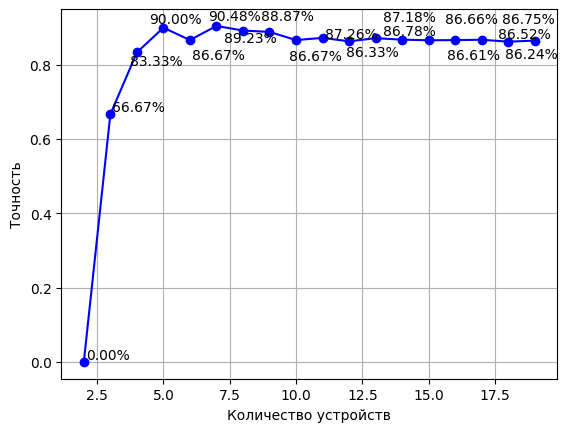

In [55]:
plt.plot(devices_amount, accuracy, 'bo-')
texts = []
for i, txt in enumerate(accuracy):
    texts.append(plt.annotate(f'{accuracy[i]:.2%}', (devices_amount[i], accuracy[i])))
adjust_text(texts)
plt.xlabel('Количество устройств')
plt.ylabel('Точность')
plt.grid()
plt.show()

In [57]:
intervals_timing = []
accuracy = []
for intervals in range(60, 600, 60):
    intervals_timing.append(intervals)
    os.makedirs(f"../data/generated_trajectory_data/time_intervals", exist_ok=True)
    generate_trajectory_data(
        num_devices=10,
        duration_minutes=120,
        interval_seconds=intervals,
        start_datetime=datetime(2022, 9, 6, 7, 30),
        center_lat=55.8935,
        center_lon=37.6028,
        output_path=f"../data/generated_trajectory_data/time_intervals/generated_trajectory_data_{intervals}.parquet"
    )
    generate_targets_df(
        input_trajectory_path=f"../data/generated_trajectory_data/time_intervals/generated_trajectory_data_{intervals}.parquet",
        output_path=f"../data/generated_trajectory_data/time_intervals/generated_targets_{intervals}.parquet"
    )
    temp_traj = pd.read_parquet(f"../data/generated_trajectory_data/time_intervals/generated_trajectory_data_{intervals}.parquet")
    temp_targets = pd.read_parquet(f"../data/generated_trajectory_data/time_intervals/generated_targets_{intervals}.parquet")
    temp_data = apply_targets_to_data(temp_traj, temp_targets)
    temp_data['predicted_proba'] = model.predict_proba(temp_data[features].fillna(-999))[:, 1]
    temp_data['thresh'] = 0.416
    temp_data['label'] = (temp_data['predicted_proba'] >= temp_data['thresh']).astype(int)
    accuracy.append(((temp_data['target'] == temp_data['label']).sum())/temp_data.shape[0])

Loaded trajectory data with 5400 rows
Распределение таргетов: 720 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 2700 rows
Распределение таргетов: 360 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 1800 rows
Распределение таргетов: 240 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 1350 rows
Распределение таргетов: 180 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 1080 rows
Распределение таргетов: 144 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 900 rows
Распределение таргетов: 120 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 765 rows
Распределение таргетов: 102 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 675 rows
Распределение таргетов: 90 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 585 rows
Распределение таргетов: 78 количество строк с таргетом == 1 (13.33%)


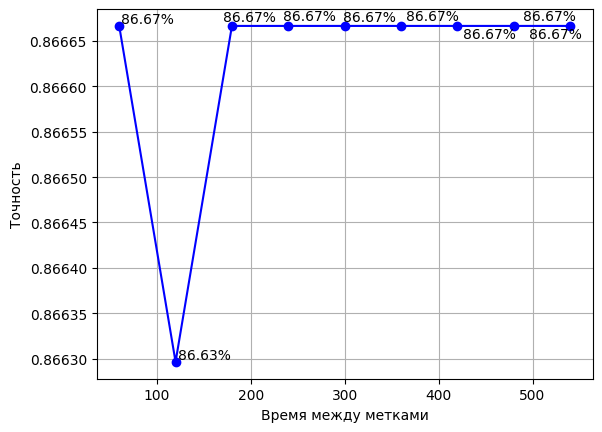

In [58]:
plt.plot(intervals_timing, accuracy, 'bo-')
texts = []
for i, txt in enumerate(accuracy):
    texts.append(plt.annotate(f'{accuracy[i]:.2%}', (intervals_timing[i], accuracy[i])))
adjust_text(texts)
plt.xlabel('Время между метками')
plt.ylabel('Точность')
plt.grid()
plt.show()

In [ ]:
durations = []
accuracy = []
for duration in range(60, 600, 60):
    durations.append(duration)
    os.makedirs(f"../data/generated_trajectory_data/durations", exist_ok=True)
    generate_trajectory_data(
        num_devices=10,
        duration_minutes=duration,
        interval_seconds=60,
        start_datetime=datetime(2022, 9, 6, 7, 30),
        center_lat=55.8935,
        center_lon=37.6028,
        output_path=f"../data/generated_trajectory_data/durations/generated_trajectory_data_{duration}.parquet"
    )
    generate_targets_df(
        input_trajectory_path=f"../data/generated_trajectory_data/durations/generated_trajectory_data_{duration}.parquet",
        output_path=f"../data/generated_trajectory_data/durations/generated_targets_{duration}.parquet"
    )
    temp_traj = pd.read_parquet(f"../data/generated_trajectory_data/durations/generated_trajectory_data_{duration}.parquet")
    temp_targets = pd.read_parquet(f"../data/generated_trajectory_data/durations/generated_targets_{duration}.parquet")
    temp_data = apply_targets_to_data(temp_traj, temp_targets)
    temp_data['predicted_proba'] = model.predict_proba(temp_data[features].fillna(-999))[:, 1]
    temp_data['thresh'] = 0.416
    temp_data['label'] = (temp_data['predicted_proba'] >= temp_data['thresh']).astype(int)
    accuracy.append(((temp_data['target'] == temp_data['label']).sum())/temp_data.shape[0])

Loaded trajectory data with 2700 rows
Распределение таргетов: 360 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 5400 rows
Распределение таргетов: 720 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 8100 rows
Распределение таргетов: 1080 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 10800 rows
Распределение таргетов: 1440 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 13500 rows
Распределение таргетов: 1800 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 16200 rows
Распределение таргетов: 2160 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 18900 rows
Распределение таргетов: 2520 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 21600 rows
Распределение таргетов: 2880 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 24300 rows
Распределение таргетов: 3240 количество строк с таргетом == 1 (13.33%)


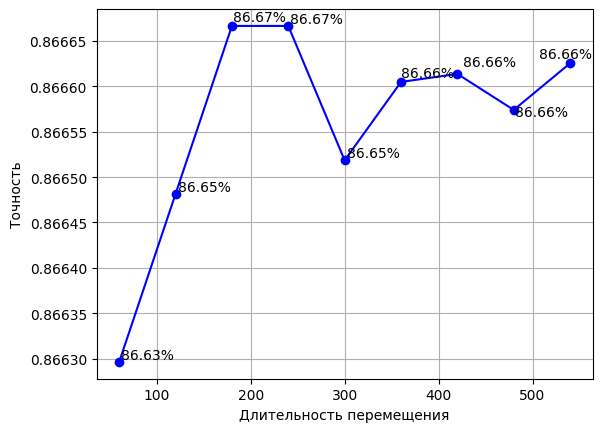

In [ ]:
plt.plot(durations, accuracy, 'bo-')
texts = []
for i, txt in enumerate(accuracy):
    texts.append(plt.annotate(f'{accuracy[i]:.2%}', (durations[i], accuracy[i])))
adjust_text(texts)
plt.xlabel('Длительность перемещения')
plt.ylabel('Точность')
plt.grid()
plt.show()

In [62]:
percentages = []
accuracy = []
for percentage in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    percentages.append(percentage)
    os.makedirs(f"../data/generated_trajectory_data/percentages", exist_ok=True)
    generate_trajectory_data(
        num_devices=10,
        duration_minutes=120,
        interval_seconds=60,
        start_datetime=datetime(2022, 9, 6, 7, 30),
        center_lat=55.8935,
        center_lon=37.6028,
        output_path=f"../data/generated_trajectory_data/percentages/generated_trajectory_data_{percentage}.parquet"
    )
    generate_targets_df(
        input_trajectory_path=f"../data/generated_trajectory_data/percentages/generated_trajectory_data_{percentage}.parquet",
        output_path=f"../data/generated_trajectory_data/percentages/generated_targets_{percentage}.parquet",
        related_percentage=percentage
    )
    temp_traj = pd.read_parquet(f"../data/generated_trajectory_data/percentages/generated_trajectory_data_{percentage}.parquet")
    temp_targets = pd.read_parquet(f"../data/generated_trajectory_data/percentages/generated_targets_{percentage}.parquet")
    temp_data = apply_targets_to_data(temp_traj, temp_targets)
    temp_data['predicted_proba'] = model.predict_proba(temp_data[features].fillna(-999))[:, 1]
    temp_data['thresh'] = 0.416
    temp_data['label'] = (temp_data['predicted_proba'] >= temp_data['thresh']).astype(int)
    accuracy.append(((temp_data['target'] == temp_data['label']).sum())/temp_data.shape[0])

Loaded trajectory data with 5400 rows
Распределение таргетов: 240 количество строк с таргетом == 1 (4.44%)
Loaded trajectory data with 5400 rows
Распределение таргетов: 720 количество строк с таргетом == 1 (13.33%)
Loaded trajectory data with 5400 rows
Распределение таргетов: 1080 количество строк с таргетом == 1 (20.00%)
Loaded trajectory data with 5400 rows
Распределение таргетов: 1440 количество строк с таргетом == 1 (26.67%)
Loaded trajectory data with 5400 rows
Распределение таргетов: 1800 количество строк с таргетом == 1 (33.33%)
Loaded trajectory data with 5400 rows
Распределение таргетов: 2160 количество строк с таргетом == 1 (40.00%)
Loaded trajectory data with 5400 rows
Распределение таргетов: 2520 количество строк с таргетом == 1 (46.67%)
Loaded trajectory data with 5400 rows
Распределение таргетов: 3000 количество строк с таргетом == 1 (55.56%)
Loaded trajectory data with 5400 rows
Распределение таргетов: 3360 количество строк с таргетом == 1 (62.22%)


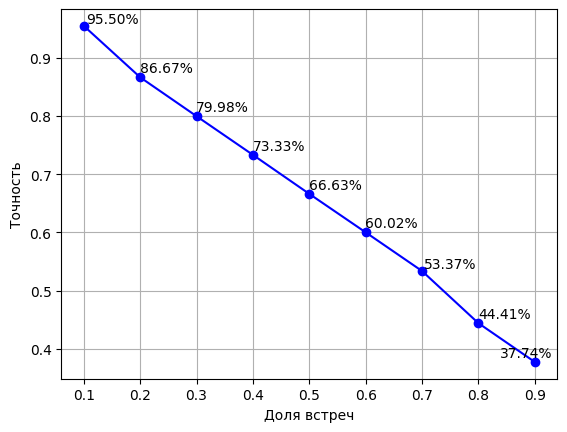

In [64]:
plt.plot(percentages, accuracy, 'bo-')
texts = []
for i, txt in enumerate(accuracy):
    texts.append(plt.annotate(f'{accuracy[i]:.2%}', (percentages[i], accuracy[i])))
adjust_text(texts)
plt.xlabel('Доля встреч')
plt.ylabel('Точность')
plt.grid()
plt.show()